## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

1. Download and import Load the smoking dataset from: [https://data.princeton.edu/wws509/datasets/#smoking](https://data.princeton.edu/wws509/datasets/#smoking). Then perform a train-test split on the data;
2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables;
3. Evaluate the regression fit on test data using MAE and MSE error metrics.

In [1]:
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
from sklearn import datasets
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

In [2]:
# load data from csv and remove NA values
data = pd.read_table("data/smoking.raw", delim_whitespace=True, header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       36 non-null     int64
 1   1       36 non-null     int64
 2   2       36 non-null     int64
 3   3       36 non-null     int64
dtypes: int64(4)
memory usage: 1.2 KB


In [3]:
data.columns = ["age", "smoke", "pop", "dead"]

data.head(3)

,age,smoke,pop,dead
0,1,1,656,18
1,2,1,359,22
2,3,1,249,19


In [4]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [5]:
x_test = torch.stack([torch.tensor(test_dataset.dataset[column].values[test_dataset.indices], dtype=torch.float64)
                           for column in ["age","smoke","pop"]], 1)
y_test = torch.tensor(test_dataset.dataset.dead.values[test_dataset.indices], dtype=torch.int64)

x_train = torch.stack([torch.tensor(train_dataset.dataset[column].values[train_dataset.indices], dtype=torch.float64)
                           for column in ["age","smoke","pop"]], 1)
y_train = torch.tensor(train_dataset.dataset.dead.values[train_dataset.indices], dtype=torch.float64)


print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([28, 3]) 
y_train.shape = torch.Size([28])

x_test.shape = torch.Size([8, 3]) 
y_test.shape = torch.Size([8])


In our model we have : 

\begin{align*}
\mu_i &= \exp(w_1\,x_1+w_2\,x_2+w_3\,x_3+b)\\
y &\sim \text{Poisson}(\mu_i).
\end{align*}





Then we define the family of posterior distributions, by setting a Gamma distribution on $w$ and a Log-Normal on $b$, and run SVI inference on $(x,y)$ data.

Notice the prior distribution on the bias term makes this regression problem analytically intractable.

In [17]:
# modelling rain in terms of the predictors
def smoke_model(predictors, deaths):
    with torch.no_grad():
        n_observations, n_predictors = predictors.shape
    
        # sample weights
        w = pyro.sample("w", dist.Cauchy(torch.zeros(n_predictors), 
                                        torch.tensor([0.00001,0.00001,0.00001])))
        b = pyro.sample("b", dist.Uniform(-1, 0))
    
        yhat = np.exp((w*predictors).sum(dim=1) + b)
        
        # condition on the observations
        with pyro.plate("deaths", len(deaths)):
            pyro.sample("obs", dist.Poisson(yhat), obs=deaths)
        
def smoke_guide(predictors, deaths=None):
    
    n_observations, n_predictors = predictors.shape
        
    w_loc = pyro.param("w_loc", torch.rand(n_predictors), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.rand(n_predictors)/1000, 
                         constraint=constraints.positive)
    
    w = pyro.sample("w", dist.Gamma(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)
    
    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))
    
    
smokeguide = pyro.infer.autoguide.AutoMultivariateNormal(smoke_model)

smoke_svi = SVI(model=smoke_model, guide=smokeguide, 
              optim=optim.ClippedAdam({'lr' : 0.01}), 
              loss=Trace_ELBO()) 

for step in range(2000):
    loss = smoke_svi.step(x_train, y_train)/len(x_train)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 2198.156124143573
Step 100 : loss = 2084.10816567456
Step 200 : loss = 2142.0099109553785
Step 300 : loss = 1637.838734830768
Step 400 : loss = 1389.1052393506518
Step 500 : loss = 3028.401209932028
Step 600 : loss = 903.4101238552794
Step 700 : loss = 701.7297732604164
Step 800 : loss = 2084.0962149151715
Step 900 : loss = 2142.017061711232
Step 1000 : loss = 1637.8441864588206
Step 1100 : loss = 1389.1096763693818
Step 1200 : loss = 3028.412376185334
Step 1300 : loss = 903.4146705110654
Step 1400 : loss = 701.7207284130948
Step 1500 : loss = 2084.104590237971
Step 1600 : loss = 2142.024016567193
Step 1700 : loss = 1637.850612660146
Step 1800 : loss = 1389.1165756121334
Step 1900 : loss = 3028.4194285701897


In [41]:
param = list(pyro.get_param_store().keys())
print("Inferred params:", param, end="\n\n")

inferred = pyro.get_param_store()[param[0]]

# w_i and b posterior mean
#inferred_w = pyro.get_param_store()["w_loc"]
#inferred_b = pyro.get_param_store()["b_loc"]

inferred_w = inferred[0:3]
inferred_b = inferred[3]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['AutoLaplaceApproximation.loc', 'AutoMultivariateNormal.loc', 'AutoMultivariateNormal.scale_tril']

w_0 = 0.00085607
w_1 = 0.00085807
w_2 = 0.00086191
b = 0.00000005


In [42]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=smoke_model, guide=smokeguide, num_samples=100,
                        return_sites=("w","b"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(x_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

       mean  std        5%       50%       95%
0  0.000856  0.0  0.000856  0.000856  0.000856
1  0.000858  0.0  0.000858  0.000858  0.000858
2  0.000862  0.0  0.000862  0.000862  0.000862

Sampled parameter = b

   mean  std   5%  50%  95%
0  -0.5  0.0 -0.5 -0.5 -0.5



In [44]:
# compute predictions using the inferred paramters
y_pred = (inferred_w * x_test).sum(1) + inferred_b 

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())



MAE = 131.183378485426
MSE = 25360.296325768784


## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

In [113]:
iris = datasets.load_iris()

df = pd.DataFrame (iris.data, columns = iris.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [114]:
# dataset normalization
df = (df-df.min())/(df.max()-df.min())
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [117]:
df['Species'] = pd.Series(iris.target)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,0.222222,0.625000,0.067797,0.041667,0
1,0.166667,0.416667,0.067797,0.041667,0
2,0.111111,0.500000,0.050847,0.041667,0
3,0.083333,0.458333,0.084746,0.041667,0
4,0.194444,0.666667,0.067797,0.041667,0


In [118]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(df, [train_size, test_size])

In [119]:
x_test = torch.stack([torch.tensor(test_dataset.dataset[column].values[test_dataset.indices], dtype=torch.float64)
                           for column in ["sepal length (cm)","sepal width (cm)","petal length (cm)", "petal width (cm)"]], 1)
y_test = torch.tensor(test_dataset.dataset.Species.values[test_dataset.indices], dtype=torch.float64)

x_train = torch.stack([torch.tensor(train_dataset.dataset[column].values[train_dataset.indices], dtype=torch.float64)
                           for column in ["sepal length (cm)","sepal width (cm)","petal length (cm)", "petal width (cm)"]], 1)
y_train = torch.tensor(train_dataset.dataset.Species.values[train_dataset.indices], dtype=torch.float64)


print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([120, 4]) 
y_train.shape = torch.Size([120])

x_test.shape = torch.Size([30, 4]) 
y_test.shape = torch.Size([30])


Step 0 : loss = 1.2491825308427347
Step 1000 : loss = 1.2396526230861116
Step 2000 : loss = 1.1134286067024581
Step 3000 : loss = 1.1208584752345907
Step 4000 : loss = 1.0116466747953239
Step 5000 : loss = 1.0804426408612455
Step 6000 : loss = 1.0467457419347752
Step 7000 : loss = 1.0042207423639973
Step 8000 : loss = 1.0147735309042374
Step 9000 : loss = 0.9414454003734671


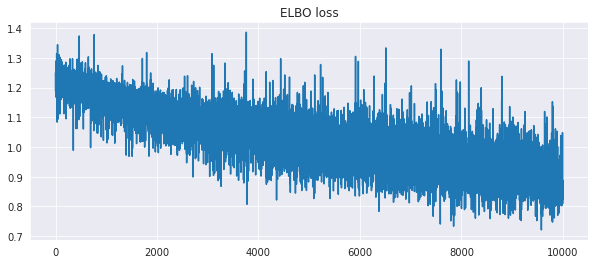

In [158]:
# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    w_setosa = pyro.sample("w_setosa", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_setosa = pyro.sample("b_setosa", dist.Normal(0.,1.))
    w_versi = pyro.sample("w_versi", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_versi = pyro.sample("b_versi", dist.Normal(0.,1.))
    w_virgi = pyro.sample("w_virgi", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_virgi = pyro.sample("b_virgi", dist.Normal(0.,1.))
    
    # non-linearity
    yhat_setosa = torch.sigmoid((w_setosa*x).sum(dim=1) + b_setosa)
    yhat_versi = torch.sigmoid((w_versi*x).sum(dim=1) + b_versi)
    yhat_virgi = torch.sigmoid((w_virgi*x).sum(dim=1) + b_virgi)
    
    yhat = torch.stack([yhat_setosa, yhat_versi, yhat_virgi], dim=1)
    
    with pyro.plate("data", n_observations):
        y = pyro.sample("y", dist.Categorical(probs=yhat), obs=y)
        
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_setosa_loc = pyro.param("w_setosa_loc", torch.rand(n_predictors))
    w_setosa_scale = pyro.param("w_setosa_scale", torch.rand(n_predictors))
    w_setosa = pyro.sample("w_setosa", dist.Normal(w_setosa_loc, w_setosa_scale))
    b_setosa_loc = pyro.param("b_setosa_loc", torch.rand(1))
    b_setosa_scale = pyro.param("b_setosa_scale", torch.rand(1))
    b_setosa = pyro.sample("b_setosa", dist.Normal(b_setosa_loc, b_setosa_scale))
    
    w_versi_loc = pyro.param("w_versi_loc", torch.rand(n_predictors))
    w_versi_scale = pyro.param("w_versi_scale", torch.rand(n_predictors)) 
    w_versi = pyro.sample("w_versi", dist.Normal(w_versi_loc, w_versi_scale))
    b_versi_loc = pyro.param("b_versi_loc", torch.rand(1))
    b_versi_scale = pyro.param("b_versi_scale", torch.rand(1))
    b_versi = pyro.sample("b_versi", dist.Normal(b_versi_loc, b_versi_scale))
    
    w_virgi_loc = pyro.param("w_virgi_loc", torch.rand(n_predictors))
    w_virgi_scale = pyro.param("w_virgi_scale", torch.rand(n_predictors))
    w_virgi = pyro.sample("w_virgi", dist.Normal(w_virgi_loc, w_virgi_scale))
    b_virgi_loc = pyro.param("b_virgi_loc", torch.rand(1))
    b_virgi_scale = pyro.param("b_virgi_scale", torch.rand(1))
    b_virgi = pyro.sample("b_virgi", dist.Normal(b_virgi_loc, b_virgi_scale))
    
    

    
log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

In [205]:
w_setosa = pyro.get_param_store()["w_setosa_loc"]
b_setosa = pyro.get_param_store()["b_setosa_loc"]

w_versi = pyro.get_param_store()["w_versi_loc"]
b_versi = pyro.get_param_store()["b_versi_loc"]

w_virgi = pyro.get_param_store()["w_virgi_loc"]
b_virgi = pyro.get_param_store()["b_virgi_loc"]


def predict_class(x):
    out_setosa = torch.sigmoid((w_setosa * x).sum(dim=1) + b_setosa)
    out_versi = torch.sigmoid((w_versi * x).sum(dim=1) + b_versi)
    out_virgi = torch.sigmoid((w_virgi * x).sum(dim=1) + b_virgi)
    
    out = torch.stack([out_setosa, out_versi, out_virgi], dim=1)
    
    return (torch.argmax(out, dim=1))




In [206]:
correct_predictions = (predict_class(x_test) == y_test).sum().item()

print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 83.33%
